In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
df=pd.read_csv('hotel.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [7]:
X = df.copy() #copying dataset to variable X
y = X.pop('is_canceled') #removing column named is_Canceled from X and saving the column in variable y

X['arrival_date_month'] = X['arrival_date_month'].map({'January':1, 'February': 2, 'March':3,'April':4, 'May':5, 'June':6, 'July':7,'August':8, 'September':9, 'October':10,'November':11,'December':12})
#changing name of months to digits
features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]#getting set of column names with numerical values
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]
#getting set of column names with categorical values
transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), 
    StandardScaler(),
)#pipeline to replace missing values with zero and Standardize features by removing the mean and scaling to unit variance
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)#pipeline to replace missing values with NA and create columns for each distinct value in categorical column

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)
#assigninf transformer_num for numerical data and transformet_cat for categorical data

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.75)#splitting for training and validation

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
#We apply fit on the training dataset and use the transform method on both - the training dataset and the test dataset.
#Thus the training, as well as the test dataset, are then transformed(scaled) using the model parameters that were learned on applying the fit method to the training dataset.
input_shape = [X_train.shape[1]]

Epoch 1/200
175/175 [==============================] - 7s 25ms/step - loss: 0.4783 - binary_accuracy: 0.7723 - val_loss: 0.4345 - val_binary_accuracy: 0.7907
Epoch 2/200
175/175 [==============================] - 4s 24ms/step - loss: 0.4222 - binary_accuracy: 0.8023 - val_loss: 0.4038 - val_binary_accuracy: 0.8084
Epoch 3/200
175/175 [==============================] - 4s 22ms/step - loss: 0.4102 - binary_accuracy: 0.8088 - val_loss: 0.3968 - val_binary_accuracy: 0.8169
Epoch 4/200
175/175 [==============================] - 3s 19ms/step - loss: 0.4026 - binary_accuracy: 0.8116 - val_loss: 0.3917 - val_binary_accuracy: 0.8192
Epoch 5/200
175/175 [==============================] - 4s 24ms/step - loss: 0.3973 - binary_accuracy: 0.8150 - val_loss: 0.3878 - val_binary_accuracy: 0.8204
Epoch 6/200
175/175 [==============================] - 4s 23ms/step - loss: 0.3933 - binary_accuracy: 0.8163 - val_loss: 0.3836 - val_binary_accuracy: 0.8232
Epoch 7/200
175/175 [==============================]

<AxesSubplot:title={'center':'Accuracy'}>

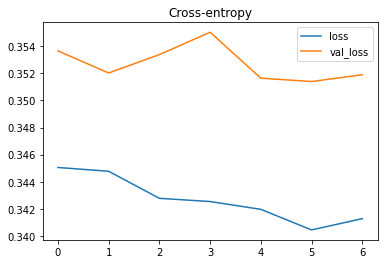

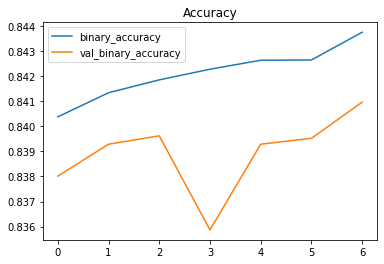

In [9]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'), 
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")